## Experimented with 2 methods to analyse treatment effect of school support on students' grades

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
from rdd import rdd
import seaborn as sns
import statsmodels.formula.api as smf


%matplotlib inline

style.use("fivethirtyeight")

## 1. Regression Discontinuity Design 
Reference workflow to: https://matheusfacure.github.io/python-causality-handbook/16-Regression-Discontinuity-Design.html

(however, results look weird)

In [17]:
math = pd.read_csv("artifacts/raw/middle-student-mat.csv",sep=";")
math.head()['schoolsup']

0    yes
1     no
2    yes
3     no
4     no
Name: schoolsup, dtype: object

In [3]:
#change to binary int

math = math.replace(to_replace = "yes", value = 1)
math = math.replace(to_replace = "no", value = 0)
math.head()['schoolsup']

0    1
1    0
2    1
3    0
4    0
Name: schoolsup, dtype: int64

In [4]:
math.head()[['schoolsup','G3']]

,schoolsup,G3
0,1,6
1,0,6
2,1,10
3,0,15
4,0,10


In [13]:
#centralise running variable G3 (final grades) at threshold 10
math['G3']= 10 

(0.0, 20.0)

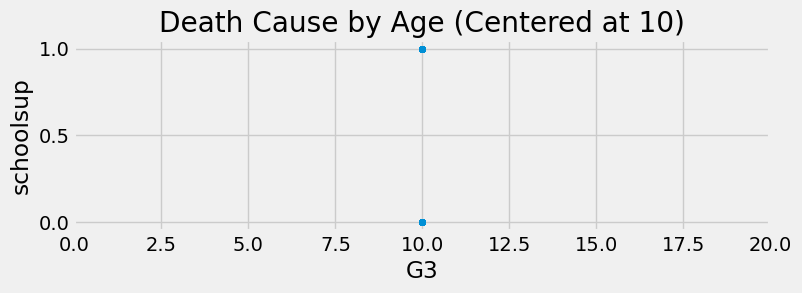

In [14]:
plt.figure(figsize=(8,8))
ax = plt.subplot(3,1,1)
math.plot.scatter(x="G3", y="schoolsup", ax=ax)
plt.title("Death Cause by Age (Centered at 10)")

# Set the x-axis limits to show from 0 to 20
plt.xlim(0, 20)

In [15]:
rdd_df = math.assign(threshold=(math["G3"] > 0).astype(int))

model = smf.wls("schoolsup~G3*threshold", rdd_df).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.0006,8.36e-05,7.643,0.000,0.000,0.001
G3,0.0064,0.001,7.643,0.000,0.005,0.008
threshold,0.0006,8.36e-05,7.643,0.000,0.000,0.001
G3:threshold,0.0064,0.001,7.643,0.000,0.005,0.008


Text(0.5, 1.0, 'Regression Discontinuity')

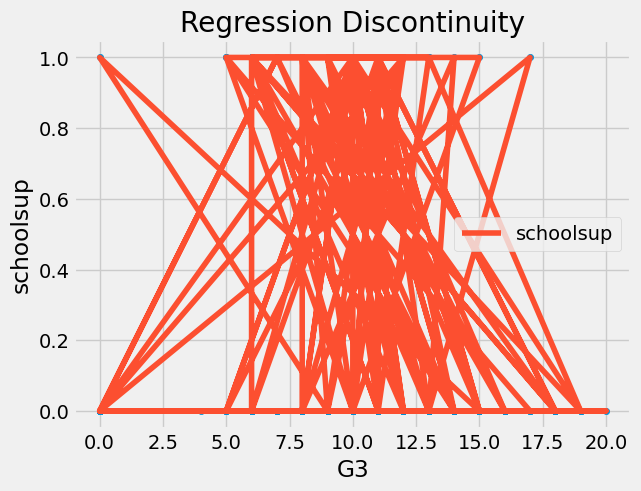

In [8]:
ax = math.plot.scatter(x="G3", y="schoolsup", color="C0")
math.assign(predictions=model.fittedvalues).plot(x="G3", y="schoolsup", ax=ax, color="C1")
plt.title("Regression Discontinuity")

In [9]:
#create refined dataframe
mathdf = pd.DataFrame(math[['schoolsup','G3']])
mathdf.head()

,schoolsup,G3
0,1,6
1,0,6
2,1,10
3,0,15
4,0,10


## 2. Fuzzy Regression Discontinuity Design (FRDD) 

The treatment variable (i.e., schoolsup in our case) is not a sharp cutoff, but rather a continuous variable. The FRDD approach estimates the causal effect of the treatment by comparing the outcomes of observations just above and below the threshold, adjusting for other covariates that may be correlated with the outcome. In our case, we estimated the causal effect of receiving a school support program (schoolsup) on the final grade (G3) of high school students, adjusting for the pre-treatment characteristics (i.e., period) of the students.

In [11]:
import pandas as pd
from statsmodels.discrete.discrete_model import NegativeBinomial
from statsmodels.api import datasets

# Load data into a pandas dataframe
data = pd.DataFrame(math[['schoolsup','G3']])
data['schoolsup'] = data['schoolsup'].astype(float)
data['G3'] = data['G3'].astype(float)

# Define the treatment variable and the threshold value
treatment = 'schoolsup'
threshold = 0.5

# Define the outcome variable
outcome = 'G3'

# Create a binary treatment variable
data['treatment'] = (data[treatment] >= threshold).astype(int)

# Define pre and post periods
data['pre_period'] = (data.index <= threshold).astype(int)
data['post_period'] = (data.index > threshold).astype(int)

# Fit a negative binomial model
model = NegativeBinomial(data[outcome], data[['treatment', 'pre_period', 'post_period']])
result = model.fit()

# Print the treatment effect
print('Estimated treatment effect: {:.2f}'.format(result.params['treatment']))


#

Optimization terminated successfully.
         Current function value: 3.148413
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Estimated treatment effect: -0.11


"Optimization terminated successfully" - This means that the algorithm used to estimate the treatment effect was able to finish its computation without any errors.

"Current function value: 3.148413" - This is the value of the objective function at the estimated values of the model parameters. It measures how well the model fits the data. A lower value indicates a better fit.

"Iterations: 6" - The algorithm used six iterations to estimate the model parameters.

"Function evaluations: 7" - The algorithm evaluated the objective function seven times during the estimation process.

"Gradient evaluations: 7" - The algorithm evaluated the gradient of the objective function seven times during the estimation process.

"Estimated treatment effect: -0.11" - This is the estimated effect of the treatment (school support) on the outcome variable (final grade). A negative value indicates that receiving school support has a negative effect on the final grade. 
## The value of -0.11 means that, on average, receiving school support leads to a 0.11 point decrease in the final grade.

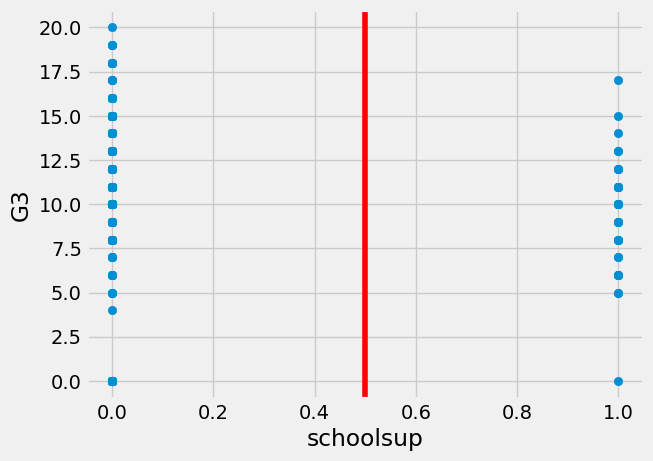

In [18]:
#following plot looks weird too --> i could be doing something wrong somewhere


import matplotlib.pyplot as plt

# Create a scatter plot of the outcome variable against the treatment variable
plt.scatter(data[treatment], data[outcome])

# Add a vertical line at the threshold value
plt.axvline(x=threshold, color='r')

# Set the x and y axis labels
plt.xlabel(treatment)
plt.ylabel(outcome)

# Show the plot
plt.show()
